In [1]:
import torch
from torch import nn

In [2]:
import torch
print(torch.cuda.is_available())


False


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
# !unzip "/content/new_dataset.zip"

In [6]:
train_dir = "train"
test_dir = "val"
train_dir

'train'

In [7]:
# import requests
# import zipfile
from pathlib import Path
image_path = Path("train")

Image shape:  (150, 150)


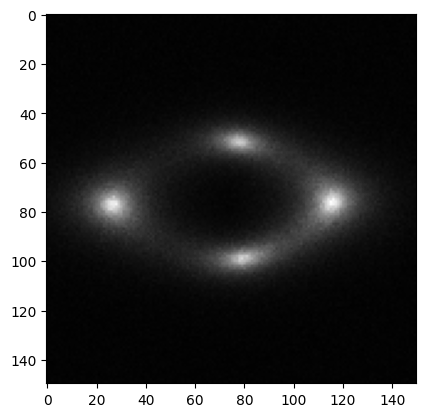


IPython -- An enhanced Interactive Python

IPython offers a fully compatible replacement for the standard Python
interpreter, with convenient shell features, special commands, command
history mechanism and output results caching.

At your system command line, type 'ipython -h' to see the command line
options available. This document only describes interactive features.

GETTING HELP
------------

Within IPython you have various way to access help:

  ?         -> Introduction and overview of IPython's features (this screen).
  object?   -> Details about 'object'.
  object??  -> More detailed, verbose information about 'object'.
  %quickref -> Quick reference of all IPython specific syntax and magics.
  help      -> Access Python's own help system.

If you are in terminal IPython you can quit this screen by pressing `q`.


MAIN FEATURES
-------------

* Access to the standard Python help with object docstrings and the Python
  manuals. Simply type 'help' (no quotes) to invoke it.

* Ma

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
file_path = 'train/no/18.npy'
array_data = np.load(file_path)
?
# If the array has a singleton dimension, remove it
if array_data.shape[0] == 1:
    array_data = array_data[0]

# Display the image
print("Image shape: ", array_data.shape)
# print(array_data)
plt.imshow(array_data, cmap='gray')  # Assuming it's a grayscale image, change cmap as needed
plt.show()


In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
image_path_list = list(image_path.glob("*/*.npy"))

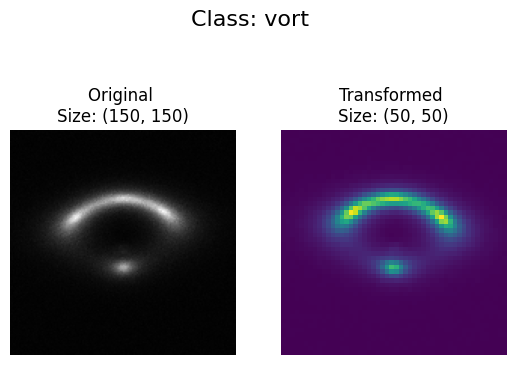

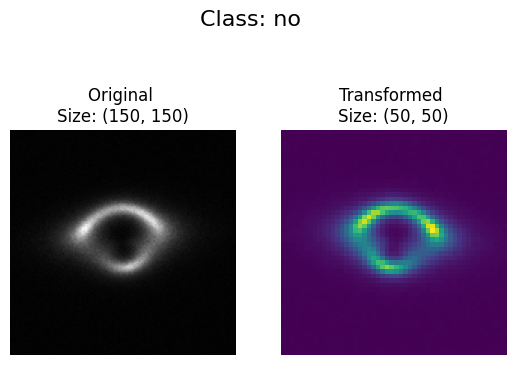

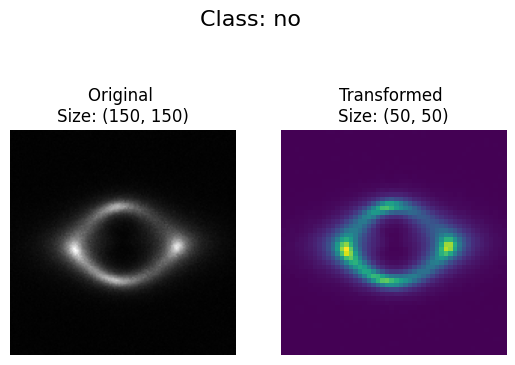

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
import random
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform, and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)

    # Adjust n if it's larger than the number of available images
    n = min(n, len(image_paths))

    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        # Load .npy file using np.load()
        array_data = np.load(image_path)

        # Remove singleton dimension if it exists
        if array_data.shape[0] == 1:
            array_data = array_data[0]

        # Convert NumPy array to PyTorch tensor
        tensor_data = torch.from_numpy(array_data).float()

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(array_data, cmap='gray')  # Assuming it's a grayscale image, adjust cmap as needed
        ax[0].set_title(f"Original \nSize: {array_data.shape}")
        ax[0].axis("off")

        # Transform and plot image
        if tensor_data.dim() == 2:  # Single-channel image
            transformed_image = transform(tensor_data.unsqueeze(0)).squeeze(0).numpy()
        else:  # Multi-channel image
            # Convert sparse tensor to dense tensor before permutation
            transformed_image = transform(tensor_data.to_dense()).permute(0, 2, 3, 1).numpy()

        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

        # Assuming the class information is in the path, adjust this as needed
        class_label = image_path.parent.stem
        fig.suptitle(f"Class: {class_label}", fontsize=16)

# Define a new transformation with a specific output size
data_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.Lambda(lambda x: x / 255.0),
    # Adjust this size according to your needs
    # Add other transformations as needed
])

# Ensure that image_path_list is not empty
if image_path_list:
    plot_transformed_images(image_path_list,
                            transform=data_transform,
                            n=3)
else:
    print("No images found in image_path_list.")


In [12]:
import os
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np

class NpyDatasetWithLabels(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = []
        self.file_list = self._list_files()
        self.classes = ['no', 'sphere', 'vort']
        # Map class names to integer labels
        self.class_to_idx = {'no' : 0, 'sphere': 1, 'vort':2}
        # self.labels = [self.class_to_idx[file.split('_')[0]] for file in self.file_list]

    def _list_files(self):
        file_list = []
        for dirpath, dirnames, filenames in os.walk(self.root_dir):
            for filename in filenames:
                if filename.endswith('.npy'):
                    file_path = os.path.join(dirpath, filename)
                    file_list.append(os.path.join(dirpath, filename))
                    parent_dir = os.path.basename(os.path.dirname(file_path))
                    if(parent_dir == 'no'):
                        self.labels.append(0)
                    elif(parent_dir == 'sphere'):
                      self.labels.append(1)
                    elif(parent_dir == 'vort'):
                      self.labels.append(2)
        return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        array_data = np.load(file_path)

        if self.transform:
            tensor_data = torch.from_numpy(array_data).float()
            tensor_data = self.transform(tensor_data)

        label = self.labels[idx]

        return tensor_data, label

    def __repr__(self):
        header = f"Dataset {self.__class__.__name__}\n"
        info = (
            f"    Number of datapoints: {len(self)}\n"
            f"    Root location: {self.root_dir}\n"
            f"    StandardTransform\n"
            f"Transform: {self.transform}\n"
        )
        return header + info

# Example usage:
data_transform = transforms.Compose([
    # transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.Lambda(lambda x: x / 255.0),  # Adjust as needed
])

train_data = NpyDatasetWithLabels(root_dir="train", transform=data_transform)
test_data = NpyDatasetWithLabels(root_dir="val",
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")



Train data:
Dataset NpyDatasetWithLabels
    Number of datapoints: 30000
    Root location: train
    StandardTransform
Transform: Compose(
    RandomHorizontalFlip(p=0.5)
)

Test data:
Dataset NpyDatasetWithLabels
    Number of datapoints: 7500
    Root location: val
    StandardTransform
Transform: Compose(
    RandomHorizontalFlip(p=0.5)
)



In [13]:
train_dir

'train'

In [14]:
# Get class names as a list
class_names = train_data.classes
class_names

['no', 'sphere', 'vort']

In [15]:
class_dict = train_data.class_to_idx
class_dict

{'no': 0, 'sphere': 1, 'vort': 2}

In [16]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.0117, 0.0156, 0.0091,  ..., 0.0182, 0.0091, 0.0130],
         [0.0156, 0.0104, 0.0130,  ..., 0.0195, 0.0169, 0.0169],
         [0.0078, 0.0143, 0.0130,  ..., 0.0169, 0.0091, 0.0091],
         ...,
         [0.0104, 0.0182, 0.0091,  ..., 0.0065, 0.0156, 0.0182],
         [0.0078, 0.0091, 0.0065,  ..., 0.0117, 0.0091, 0.0195],
         [0.0104, 0.0143, 0.0091,  ..., 0.0104, 0.0143, 0.0208]]])
Image shape: torch.Size([1, 150, 150])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Original shape: torch.Size([1, 150, 150]) -> [color_channels, height, width]
Image permute shape: torch.Size([150, 150, 1]) -> [height, width, color_channels]


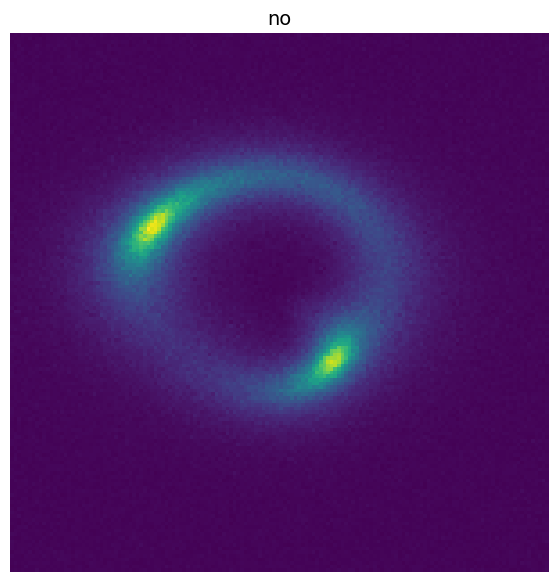

In [17]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [18]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=1,
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1fe01246950>,
 <torch.utils.data.dataloader.DataLoader at 0x1fe053ede40>)

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, use_skip_connections=True, use_batch_norm=True, use_dropout=True) -> None:
        super(TinyVGG, self).__init__()
        self.use_skip_connections = use_skip_connections
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        # Convolutional blocks
        self.conv_block_1 = self._make_conv_block(input_shape, hidden_units)
        self.conv_block_2 = self._make_conv_block(hidden_units, hidden_units)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=10 * 37 * 37, out_features=output_shape)
        )

    def _make_conv_block(self, in_channels, out_channels):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
        if self.use_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
        if self.use_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        if self.use_dropout:
            layers.append(nn.Dropout(0.25))  # Adjust dropout rate as needed

        return nn.Sequential(*layers)

    def forward(self, x):
      x1 = self.conv_block_1(x)
      x2 = self.conv_block_2(x1)

      if self.use_skip_connections:
          # Adjust dimensions of x1 to match x2
          x1 = F.interpolate(x1, size=x2.shape[2:], mode='nearest')
          x2 = x2 + x1
      # print("hello: ", x2.shape)
      x = self.classifier(x2)
      return x


# Example usage:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=1, hidden_units=10, output_shape=len(train_data.classes), use_skip_connections=True, use_batch_norm=True, use_dropout=True).to(device)
print(model_0)


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [21]:
# # 1. Get a batch of images and labels from the DataLoader
# img_batch, label_batch = next(iter(train_dataloader))

# # 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
# img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
# print(f"Single image shape: {img_single.shape}\n")

# # 3. Perform a forward pass on a single image
# model_0.eval()
# with torch.inference_mode():
#     pred = model_0(img_single.to(device))

# # 4. Print out what's happening and convert model logits -> pred probs -> pred label
# print(f"Output logits:\n{pred}\n")
# print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
# print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
# print(f"Actual label:\n{label_single}")

In [ ]:
# # Install torchinfo if it's not available, import it if it is
# try:
#     import torchinfo
# except:
#     !pip install torchinfo
#     import torchinfo

# from torchinfo import summary
# summary(model_0, input_size=[1, 1, 100, 100]) # do a test pass through of an example input size

In [20]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [21]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [22]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          # test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

c:\Users\harsh\anaconda3\envs\cuda_pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Set random seeds
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=1, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        # test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from typing import Dict, List


In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

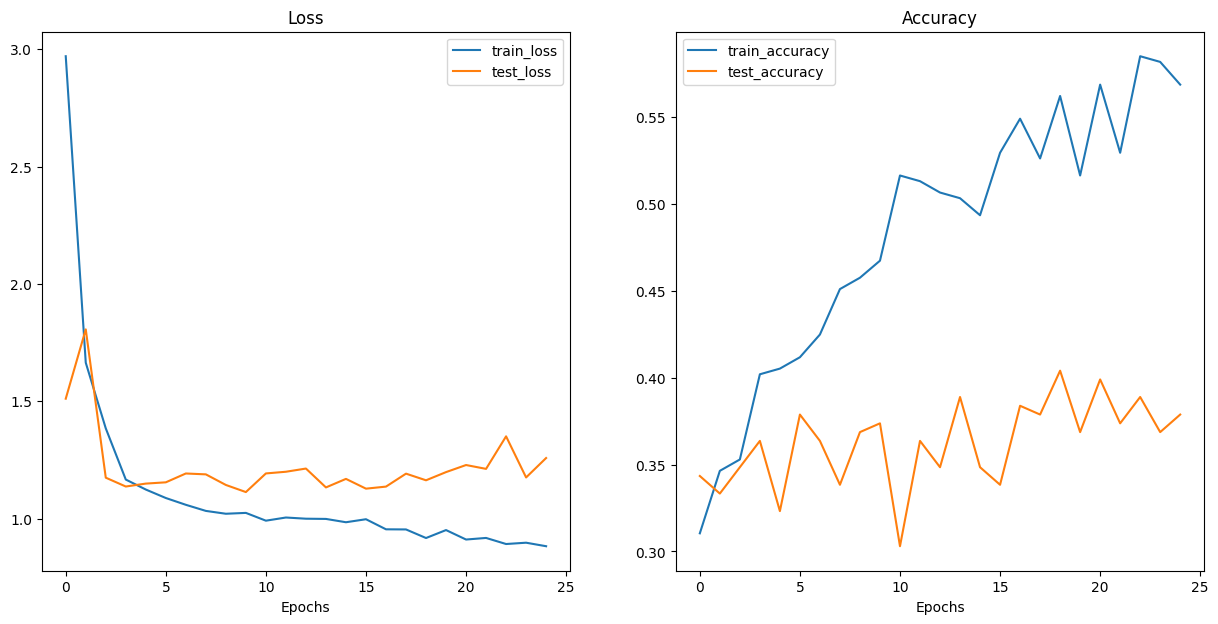

In [ ]:
plot_loss_curves(model_0_results)